The dataset was sourced form: https://www.kaggle.com/datasets/yasserh/housing-prices-dataset

Python Packages for analyzing and cleaning data:

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

## Data Inspection

Importing the dataset:

In [65]:
df = pd.read_csv("../../backend/data/housing-dataset.csv")
df.head(50)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,yes,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,no,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,yes,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,yes,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,no,furnished
5,10850000,7500,3,3,1,1,0,1,0,1,2,yes,semi-furnished
6,10150000,8580,4,3,4,1,0,0,0,1,2,yes,semi-furnished
7,10150000,16200,5,3,2,1,0,0,0,0,0,no,unfurnished
8,9870000,8100,4,1,2,1,1,1,0,1,2,yes,furnished
9,9800000,5750,3,2,4,1,1,0,0,1,1,yes,unfurnished


In [66]:
df.shape

(545, 13)

In [67]:
df.info

<bound method DataFrame.info of         price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0    13300000  7420         4          2        3         1          0   
1    12250000  8960         4          4        4         1          0   
2    12250000  9960         3          2        2         1          0   
3    12215000  7500         4          2        2         1          0   
4    11410000  7420         4          1        2         1          1   
..        ...   ...       ...        ...      ...       ...        ...   
540   1820000  3000         2          1        1         1          0   
541   1767150  2400         3          1        1         0          0   
542   1750000  3620         2          1        1         1          0   
543   1750000  2910         3          1        1         0          0   
544   1750000  3850         3          1        2         1          0   

     basement  hotwaterheating  airconditioning  parking prefarea  \
0         

In [68]:
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [69]:
df.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad             int64
guestroom            int64
basement             int64
hotwaterheating      int64
airconditioning      int64
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

## Data Cleaning

Checking for null values:

In [79]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

Value Encoding:

In [72]:
# Encoding boolean values from string to int (1 for yes, 0 for no)
boolean_columns = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"]
df[boolean_columns].replace({"yes": 1, "no": 0}, inplace=True)

# Encoding furnishing status from string to int (0 for unfurnished, 1 for semi-furnished, 2 for furnished)
df["furnishingstatus"].replace({"unfurnished": 0, "semi-furnished": 1, "furnished": 2}, inplace=True)

/var/folders/12/9kkk6tqs47d4103npslj25_40000gn/T/ipykernel_6528/285196213.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[boolean_columns].replace({"yes": 1, "no": 0}, inplace=True)


In [77]:
# Changing prefarea individually
df['prefarea'].replace({'yes': 1, 'no': 0}, inplace=True)
df.head(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2


In [78]:
df.dtypes

price               int64
area                int64
bedrooms            int64
bathrooms           int64
stories             int64
mainroad            int64
guestroom           int64
basement            int64
hotwaterheating     int64
airconditioning     int64
parking             int64
prefarea            int64
furnishingstatus    int64
dtype: object

Checking correlation between features:

<Axes: >

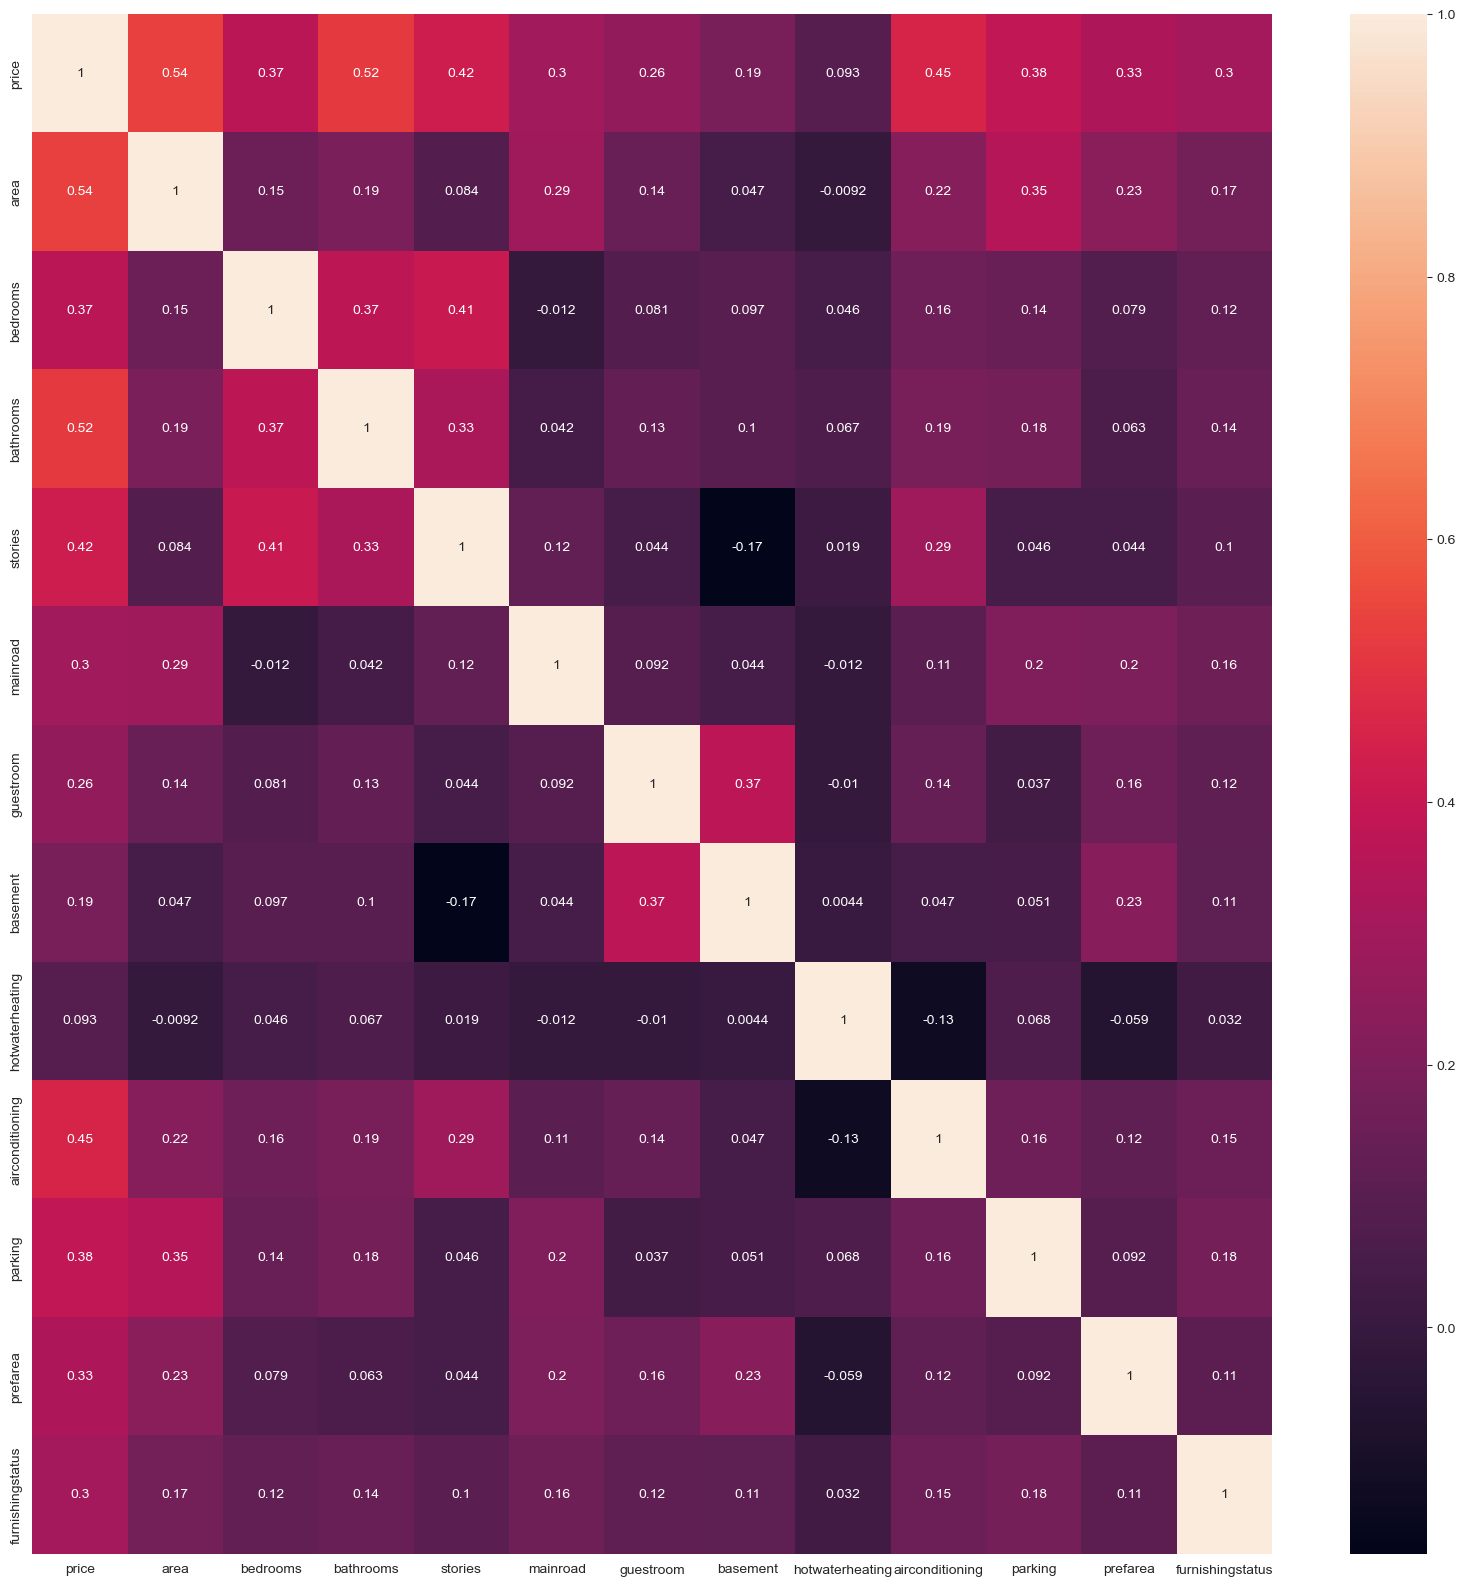

In [86]:
corr = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True)

In [81]:
corr_target = abs(corr["price"])
correlated_features = corr_target[corr_target>0.2]

names = [index for index, value in correlated_features.items()]

names.remove("price")

print(names)

['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']


## Preprocessing

Feature Scaling

In [89]:
# Saving dataset after changes
df.to_csv('../../backend/data/housing-dataset.csv', index=False)

# Creating training dataset
train_df = pd.read_csv('../../backend/data/housing-dataset.csv')
train_df.to_csv('../../backend/data/training-housing-dataset.csv')


In [90]:
train_df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2


In [44]:
scaled_columns = ["price", "area"]
scaler = sk.preprocessing.StandardScaler()
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])

AttributeError: module 'sklearn' has no attribute 'preprocessing'